In [1]:
import numpy as np
import line_racer.line_racer as lr
import os
import zarr
import zarr.codecs
import zarr.storage
import shutil
from pathlib import Path

In [2]:
# intensity correction

from line_racer.intensity_correction_precalculation import calculate_correction_grid

# Define parameters for the correction grid calculation
gamma_sigma_ratio_minimum = 1e-9
gamma_sigma_ratio_maximum = 1e6
sigma_minimum = 1e-5
sigma_maximum = 1e2
width_points = 5
cutoff_minimum = 1
cutoff_maximum = 5000
cutoff_points = 5

# calculate the grid for the Hartmann and cutoff correction
hartmann = True
hartmann_cutoff_correction_grid, sigma_grid, gamma_sigma_ratio_grid, cutoff_grid = calculate_correction_grid(
    gamma_sigma_ratio_minimum,
    gamma_sigma_ratio_maximum,
    sigma_minimum, sigma_maximum, width_points,
    cutoff_minimum, cutoff_maximum,
    cutoff_points, hartmann)

np.savez("../reference_files/reference_hartmann_cutoff_correction_grid.npz", hartmann_cutoff_correction_grid)

hartmann = False
cutoff_correction_grid, sigma_grid, gamma_sigma_ratio_grid, cutoff_grid = calculate_correction_grid(
    gamma_sigma_ratio_minimum,
    gamma_sigma_ratio_maximum,
    sigma_minimum, sigma_maximum, width_points,
    cutoff_minimum, cutoff_maximum,
    cutoff_points, hartmann)

np.savez("../reference_files/reference_cutoff_correction_grid.npz", cutoff_correction_grid)

Calculating correction grid for cutoff and using Hartmann correction 1.00 cm^-1 (1/5)
Calculating correction grid for cutoff and using Hartmann correction 8.41 cm^-1 (2/5)
Calculating correction grid for cutoff and using Hartmann correction 70.71 cm^-1 (3/5)
Calculating correction grid for cutoff and using Hartmann correction 594.60 cm^-1 (4/5)
Calculating correction grid for cutoff and using Hartmann correction 5000.00 cm^-1 (5/5)
Calculating correction grid for cutoff 1.00 cm^-1 (1/5)
Calculating correction grid for cutoff 8.41 cm^-1 (2/5)
Calculating correction grid for cutoff 70.71 cm^-1 (3/5)
Calculating correction grid for cutoff 594.60 cm^-1 (4/5)
Calculating correction grid for cutoff 5000.00 cm^-1 (5/5)


In [2]:
# define states file
upper_state = "           1 54321.54321    211     110      19   e"
lower_state = "           2 73760.69115    245     122      31   e"

os.makedirs("exomol_tests/", exist_ok=True)
with open("exomol_tests/exomol.states", "w") as f:
    f.write(upper_state + "\n")
    f.write(lower_state + "\n")

# define transition file
transition = "           1            2 1.2345E-01   187.010999"

with open("exomol_tests/exomol.trans", "w") as f:
    f.write(transition + "\n")

# define partition function
partition1 = "   797.0        295.2217"
partition2 = "  1800.0        800.0860"

with open("exomol_tests/exomol.pf", "w") as f:
    f.write(partition1 + "\n")
    f.write(partition2 + "\n")

temperatures = [797.0, 1800]
pressures = list(np.logspace(-6, 3, 5))
pressures = list(np.logspace(-6, 3, 5))


# create line racer object
exomol_test_racer = lr.LineRacer(database="exomol",
                                 input_folder="exomol_tests/",
                                 mass=18.0,
                                 hartmann=False,
                                 species_isotope_dict={"1H2-16O": 1.0},
                                 temperatures=temperatures,
                                 pressures=pressures,
                                 broadening_type="constant",
                                 constant_broadening=[0.07, 0.5]
                                 )

transition_files_list = (
    exomol_test_racer.prepare_opacity_calculation(transition_files_list=['exomol_tests/exomol.trans']))
final_cross_section_file_name = exomol_test_racer.calculate_opacity(transition_files_list, use_mpi=False)

store = zarr.storage.ZipStore(final_cross_section_file_name, mode='a')
z = zarr.group(store=store)
wavenumbers = z['wavenumbers'][:]
cross_section_exomol = z['cross-sections'][:]

ref_opacity_filename = Path("../reference_files/reference_exomol_cross_section.zarr.zip")

if ref_opacity_filename.exists():
    ref_opacity_filename.unlink()

with zarr.storage.ZipStore(ref_opacity_filename, mode='w') as store:
    root = zarr.group(store=store)

    root.create('xsec',
                shape=(len(pressures), len(temperatures), len(wavenumbers)),
                dtype='f8')

    root['xsec'][:] = cross_section_exomol


Set up to calculate the opacity for the following species with line racer: ['1H2-16O']
Using cutoff intensity correction grid and interpolated to 100.0 1/cm

 Line parameter calculation time: 0.00031638145446777344 s
Starting the line profile calculation of 1 lines

Line profile calculation done

 Line parameter calculation time: 0.0002739429473876953 s
Starting the line profile calculation of 1 lines

Line profile calculation done

 Line parameter calculation time: 0.00023412704467773438 s
Starting the line profile calculation of 1 lines

Line profile calculation done

 Line parameter calculation time: 0.0003108978271484375 s
Starting the line profile calculation of 1 lines

Line profile calculation done

 Line parameter calculation time: 0.00026607513427734375 s
Starting the line profile calculation of 1 lines

Line profile calculation done

 Line parameter calculation time: 0.0002601146697998047 s
Starting the line profile calculation of 1 lines

Line profile calculation done

 Line

(19300.0, 19600.0)

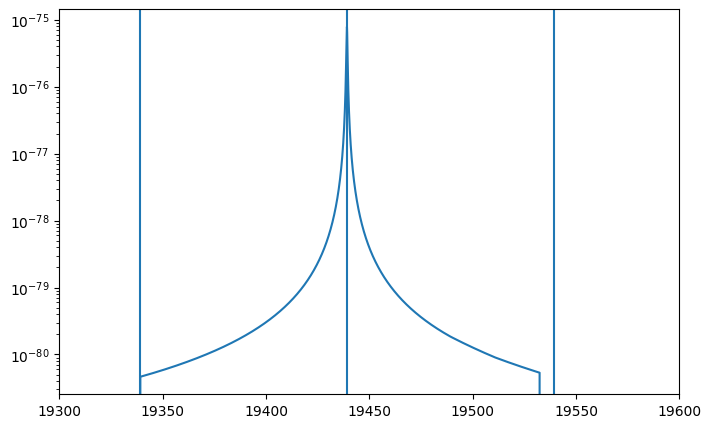

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(wavenumbers, cross_section_exomol[3, 0,:])

nueff = wavenumbers[np.argmax(cross_section_exomol[3, 0,:])]


ax.set_yscale('log')
ax.vlines(nueff, 1e-82, 1e-43)
ax.vlines(nueff -100, 1e-82, 1e-43)
ax.vlines(nueff + 100, 1e-82, 1e-43)
ax.set_xlim(19300, 19600)